In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import HopfieldEstimator

In [3]:
dataset = get_dataset("electricity")

In [4]:
estimator = HopfieldEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    dim_feedforward=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    activation="relu",

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50),
)

In [5]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=1024
)

/mnt/scratch/kashif/pytorch/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.78370 (best 5.78370), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_15/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.34423 (best 5.34423), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_15/checkpoints/epoch=1-step=200.ckpt' as top 1
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [7]:
forecasts = list(forecast_it)

In [8]:
tss = list(ts_it)

In [9]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))


Running evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2247/2247 [00:00<00:00, 20562.42it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/

In [10]:
agg_metrics

{'MSE': 1769606.3776884258,
 'abs_error': 8888097.290876685,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7591927920679361,
 'MAPE': 0.10931453450685932,
 'sMAPE': 0.11094208594957058,
 'MSIS': 6.504946785733864,
 'QuantileLoss[0.1]': 3850066.370067271,
 'Coverage[0.1]': 0.08273994956237947,
 'QuantileLoss[0.2]': 6008883.218143227,
 'Coverage[0.2]': 0.15715398308856252,
 'QuantileLoss[0.3]': 7582539.120603158,
 'Coverage[0.3]': 0.23841047322355735,
 'QuantileLoss[0.4]': 8526804.350696325,
 'Coverage[0.4]': 0.32780744696632547,
 'QuantileLoss[0.5]': 8888097.309877153,
 'Coverage[0.5]': 0.42336077733273997,
 'QuantileLoss[0.6]': 8837119.769643202,
 'Coverage[0.6]': 0.5153167185877465,
 'QuantileLoss[0.7]': 8099801.8221638175,
 'Coverage[0.7]': 0.624573505414627,
 'QuantileLoss[0.8]': 6751343.933891078,
 'Coverage[0.8]': 0.7365746921821688,
 'QuantileLoss[0.9]': 4607297.154966753,
 'Coverage[0.9]': 0.8499666221628

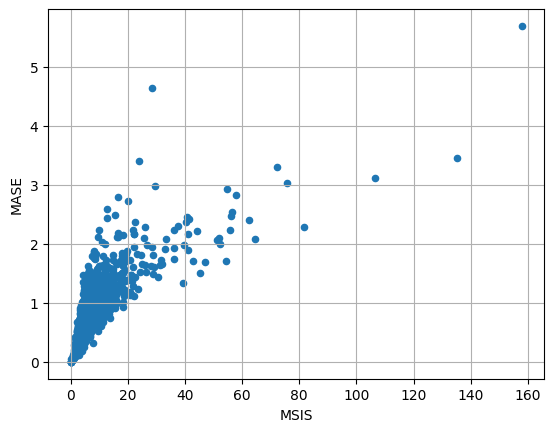

In [11]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

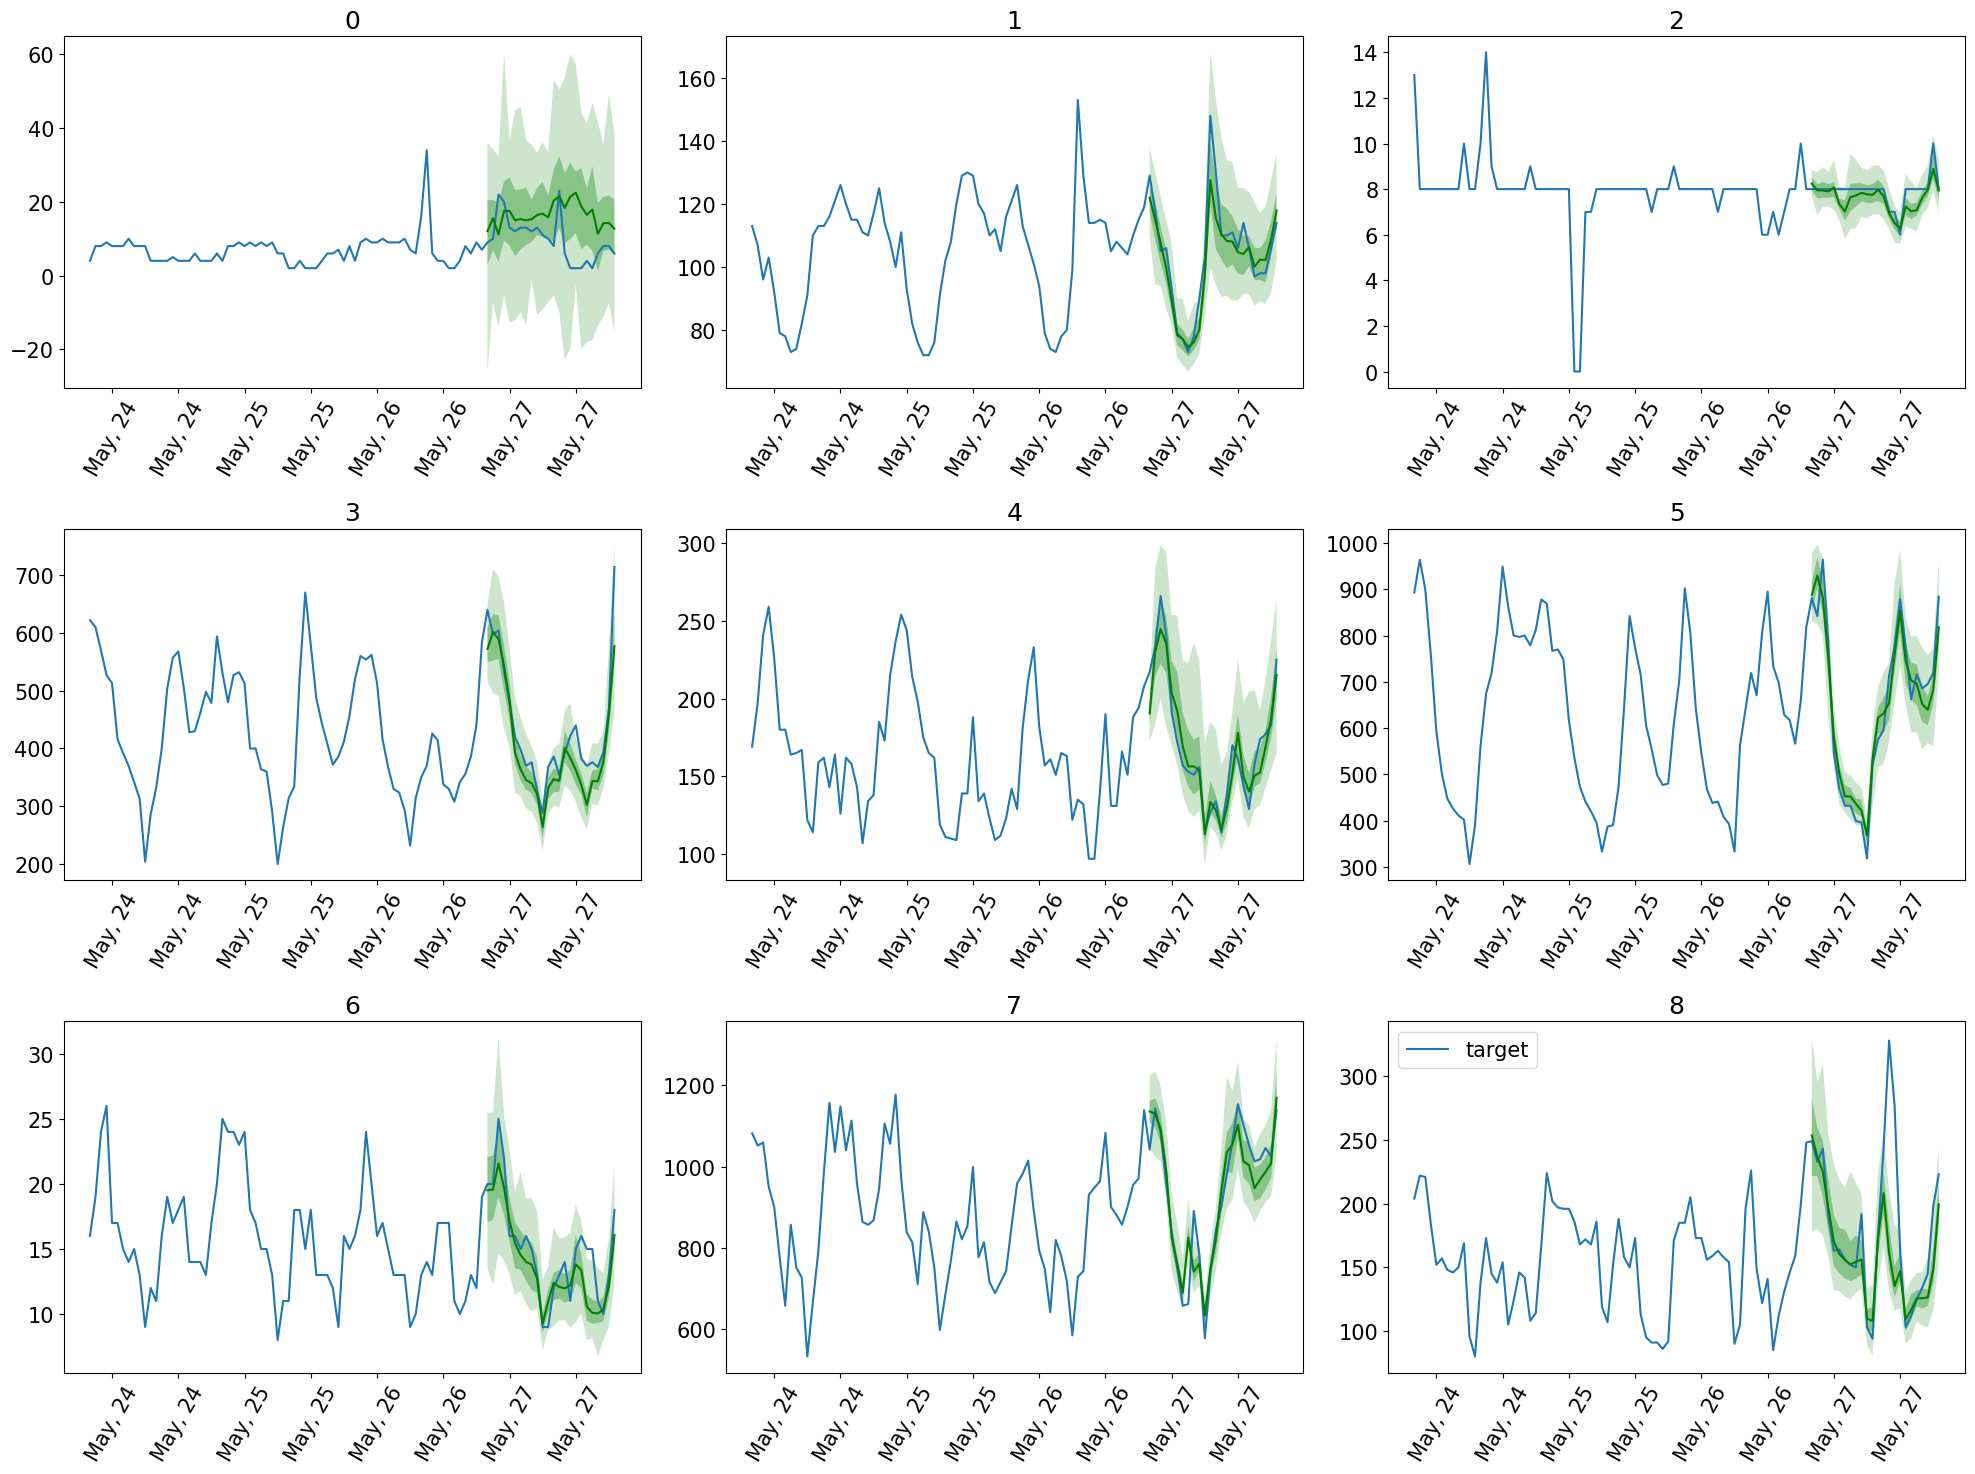

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length :].to_timestamp()

    plt.plot(
        ts[-4 * dataset.metadata.prediction_length :],
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()